# IS319 - Deep Learning

## TP2 - Dogs vs. cats (TensorFlow/Keras)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the TensorFlow/Keras library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [6]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from tensorflow.keras.applications import VGG16

TensorFlow version: 2.18.0


In [8]:
"""# Code from Tensorflow to run the code on the CPU (for time comparison)

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

# To find out which devices your operations and tensors are assigned to
tf.debugging.set_log_device_placement(True)

# Create some tensors and perform an operation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)"""

"# Code from Tensorflow to run the code on the CPU (for time comparison)\n\n# Hide GPU from visible devices\ntf.config.set_visible_devices([], 'GPU')\n\n# To find out which devices your operations and tensors are assigned to\ntf.debugging.set_log_device_placement(True)\n\n# Create some tensors and perform an operation\na = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])\nb = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])\nc = tf.matmul(a, b)\n\nprint(c)"

## Utility function

In [9]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

## 1. Load and explore the dataset

In [10]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.356.jpg', 'cat.512.jpg', 'cat.292.jpg', 'cat.518.jpg', 'cat.46.jpg', 'cat.594.jpg', 'cat.47.jpg', 'cat.533.jpg', 'cat.457.jpg', 'cat.897.jpg']
['dog.139.jpg', 'dog.603.jpg', 'dog.418.jpg', 'dog.463.jpg', 'dog.92.jpg', 'dog.354.jpg', 'dog.502.jpg', 'dog.514.jpg', 'dog.913.jpg', 'dog.476.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

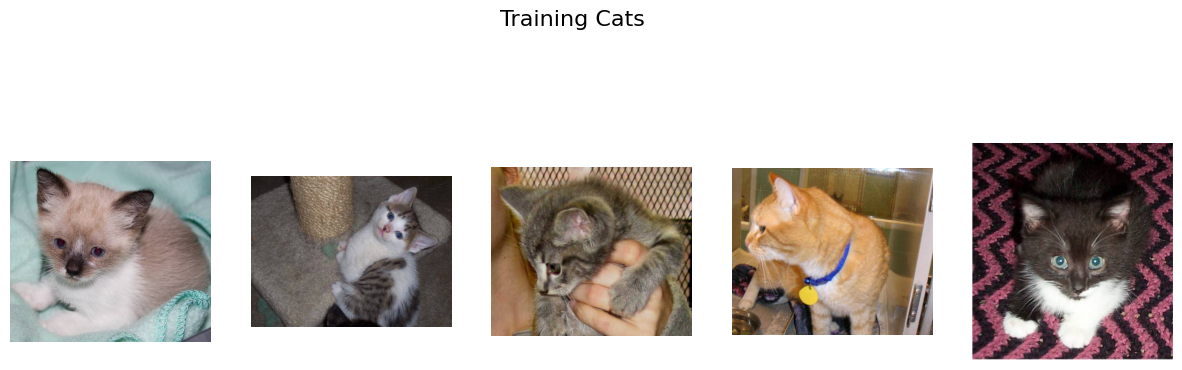

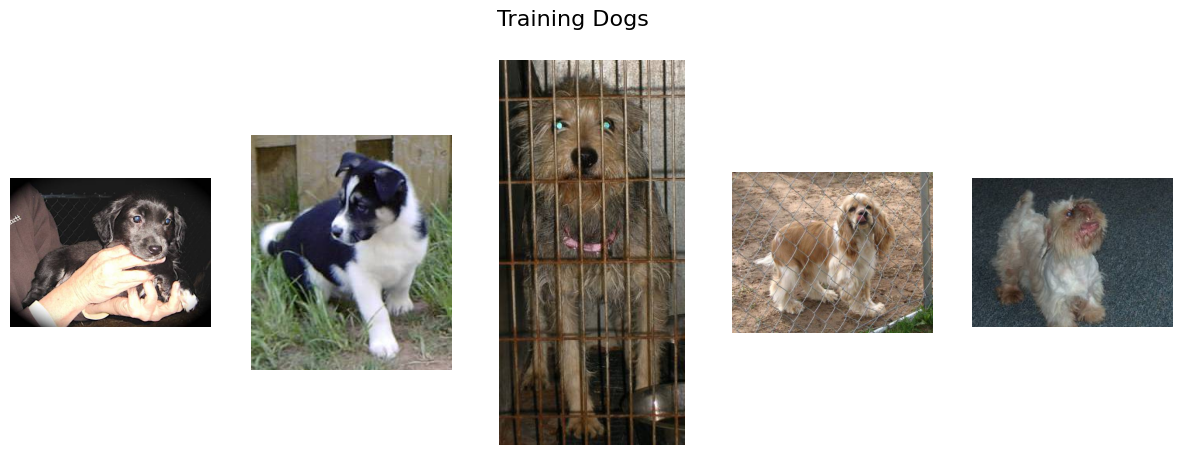

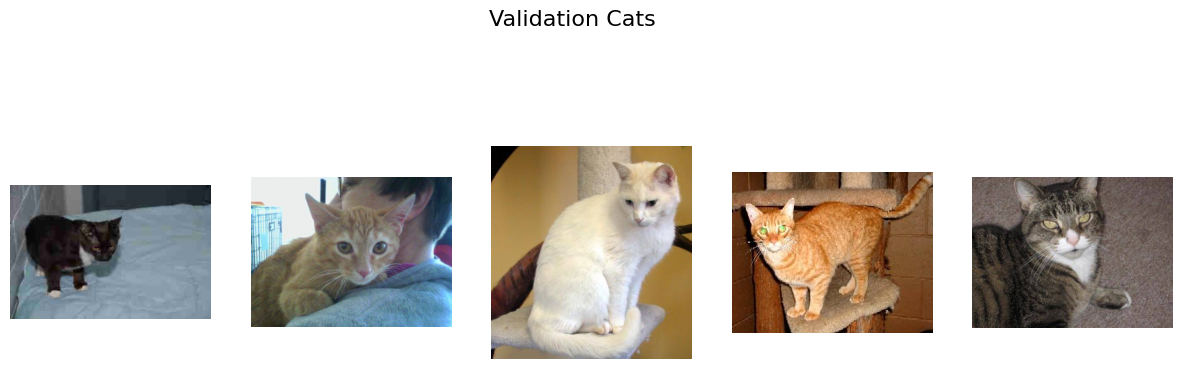

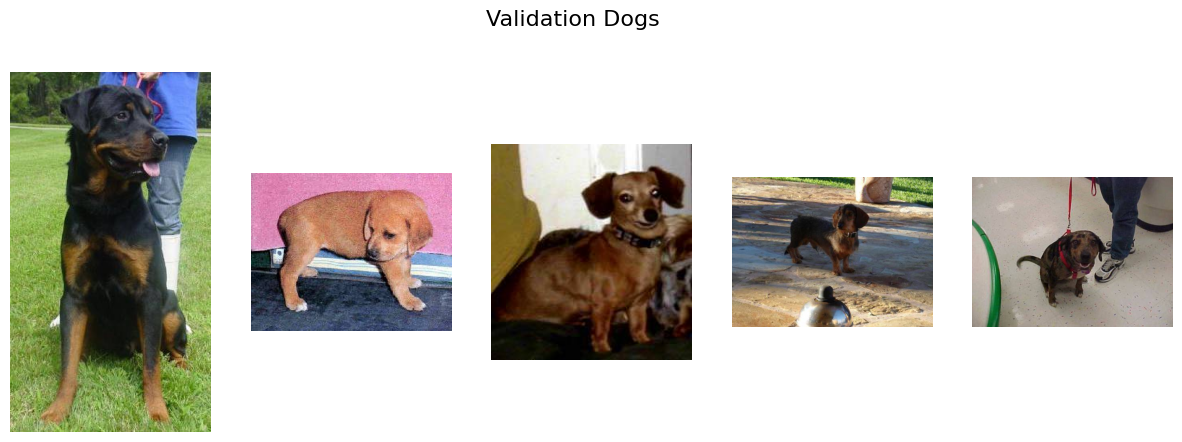

In [11]:
def display_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i, image_path in enumerate(image_paths[:n]):
        img = Image.open(image_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

train_cat_images = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)[:5]]
train_dog_images = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)[:5]]
valid_cat_images = [os.path.join(valid_cats_dir, fname) for fname in os.listdir(valid_cats_dir)[:5]]
valid_dog_images = [os.path.join(valid_dogs_dir, fname) for fname in os.listdir(valid_dogs_dir)[:5]]

display_images(train_cat_images, "Training Cats")
display_images(train_dog_images, "Training Dogs")
display_images(valid_cat_images, "Validation Cats")
display_images(valid_dog_images, "Validation Dogs")

## 2. Prepare the dataset

**(Question)** Following the documentation, use the `tf.keras.utils.image_dataset_from_directory` function to create `train_dataset` and `valid_dataset` objects from the directory paths defined above. Make sure to have binary labels as we are doing binary classification. To start, you can use a lower image size (for example 128x128).

In [14]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Set parameters for the dataset
batch_size = 32
img_height = 128
img_width = 128

training_data = ImageDataGenerator(rescale=1./255)
valid_data = ImageDataGenerator(rescale=1./255)

train_dataset = training_data.flow_from_directory(train_dir,    
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size,
                                          class_mode='binary'
                                        )

valid_dataset = valid_data.flow_from_directory(valid_dir,    
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size,
                                          class_mode='binary'
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show its summary with the `model1.summary()`method.
Make sure to include a layer to normalize input data (or to normalize your dataset object beforehand).

In [22]:
model1 = Sequential()

# Input Layer
model1.add(Conv2D(32,(3,3), activation='relu', input_shape = (128,128,3))) 
model1.add(MaxPooling2D(pool_size=(2,2)))

# Block 1 
model1.add(Conv2D(64,(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
# Block 2
model1.add(Conv2D(128,(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
# Block 3
model1.add(Conv2D(256,(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected layers 
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU: ", gpus[0])
else:
    print("No GPU found, using CPU.")

Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


**(Question)** "Compile" and train your model with an appropriate loss function. Monitor train and validation accuracy (you can use the `plot_loss_acc` function defined above). You should be able to reach a validation accuracy >70%. Analyze your results.

In [24]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,108,033 (19.49 MB)

 Trainable params: 5,108,033 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history1 = model1.fit(train_dataset, 
                    validation_data=valid_dataset, 
                    epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5408 - loss: 0.7809 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5063 - loss: 0.6928 - val_accuracy: 0.5280 - val_loss: 0.6878
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5250 - loss: 0.6878 - val_accuracy: 0.6080 - val_loss: 0.6846
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5952 - loss: 0.6747 - val_accuracy: 0.6030 - val_loss: 0.6777
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6120 - loss: 0.6714 - val_accuracy: 0.5930 - val_loss: 0.6635
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6469 - loss: 0.6329 - val_accuracy: 0.6690 - val_loss: 0.6157
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6943 - loss: 0.5808 - val_accuracy: 0.6830 - val_loss: 0.5940
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7421 - loss: 0.5227 - val_accuracy: 0.7220 - v

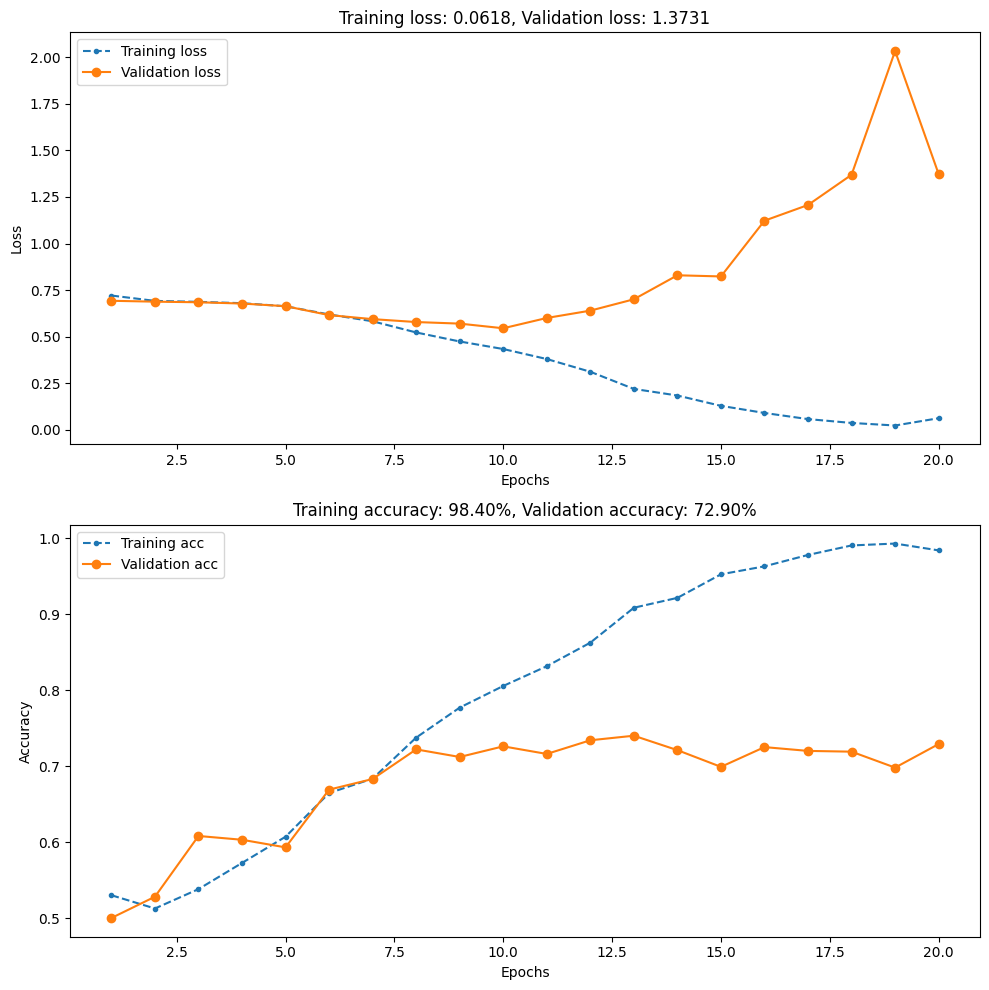

In [27]:
plot_loss_acc(history1)

This first model contains $4$ convolutional layers (including the input one), going from $32$ filters (kernels) to $256$ kernels in the last layer. After these convolutional layers, we reach the fully convolutional layer, that contains $512$ neurons. And finally, these $512$ neurons are regrouped in a single one that will be the output layer. Each internal layer is using the ReLu function as activation and the output one uses the sigmoid activation.

Then we train the model on $10$ epochs, using Adam optimizer with the binary cross entropy loss (BCE), based on the accuracy of the predictions.

Observing the plots, we see that the model seems to learn and then begins to overfit (between $10$ and $15$ as can be seen on the loss plot with the validation loss that increases while the training one is still decreasing). The same observation can be made on the accuracy plot where we observe that the vlidation one does not increase after $12$ epochs.

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

On CPU : 18min 35s (1115s)

On GPU : 14.6s

The time of fitting is therefore divided by $\approx 76$ times when using GPU.

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [29]:
augmented_training_data = ImageDataGenerator(rescale=1./255,shear_range=0.2,horizontal_flip=True,zoom_range=0.2)     
augmented_train_dataset = augmented_training_data.flow_from_directory(train_dir,    
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size,
                                          class_mode='binary'
                                        )

model2 = Sequential()

# Input Layer
model2.add(Conv2D(32,(3,3), activation='relu', input_shape = (128,128,3))) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

# Bloack 1 
model2.add(Conv2D(64,(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
# Block 2
model2.add(Conv2D(128,(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
# Block 3
model2.add(Conv2D(256,(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

# Fully Connected layers 
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

# Output layer
model2.add(Dense(1, activation='sigmoid'))

Found 2000 images belonging to 2 classes.


**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model1.

In [30]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 5,177,793 (19.75 MB)

 Trainable params: 5,175,553 (19.74 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [31]:
history2 = model1.fit(augmented_train_dataset, validation_data=valid_dataset, epochs=25)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7489 - loss: 0.6821 - val_accuracy: 0.7180 - val_loss: 0.5624
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8063 - loss: 0.4511 - val_accuracy: 0.7390 - val_loss: 0.5495
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8266 - loss: 0.3684 - val_accuracy: 0.7640 - val_loss: 0.5094
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8561 - loss: 0.3344 - val_accuracy: 0.7660 - val_loss: 0.5330
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8605 - loss: 0.3424 - val_accuracy: 0.7590 - val_loss: 0.6182
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8684 - loss: 0.3032 - val_accuracy: 0.7660 - val_loss: 0.5545
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9014 - loss: 0.2747 - val_accuracy: 0.7550 - val_loss: 0.5934
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9167 - loss: 0.2089 - val_accuracy: 0.7600

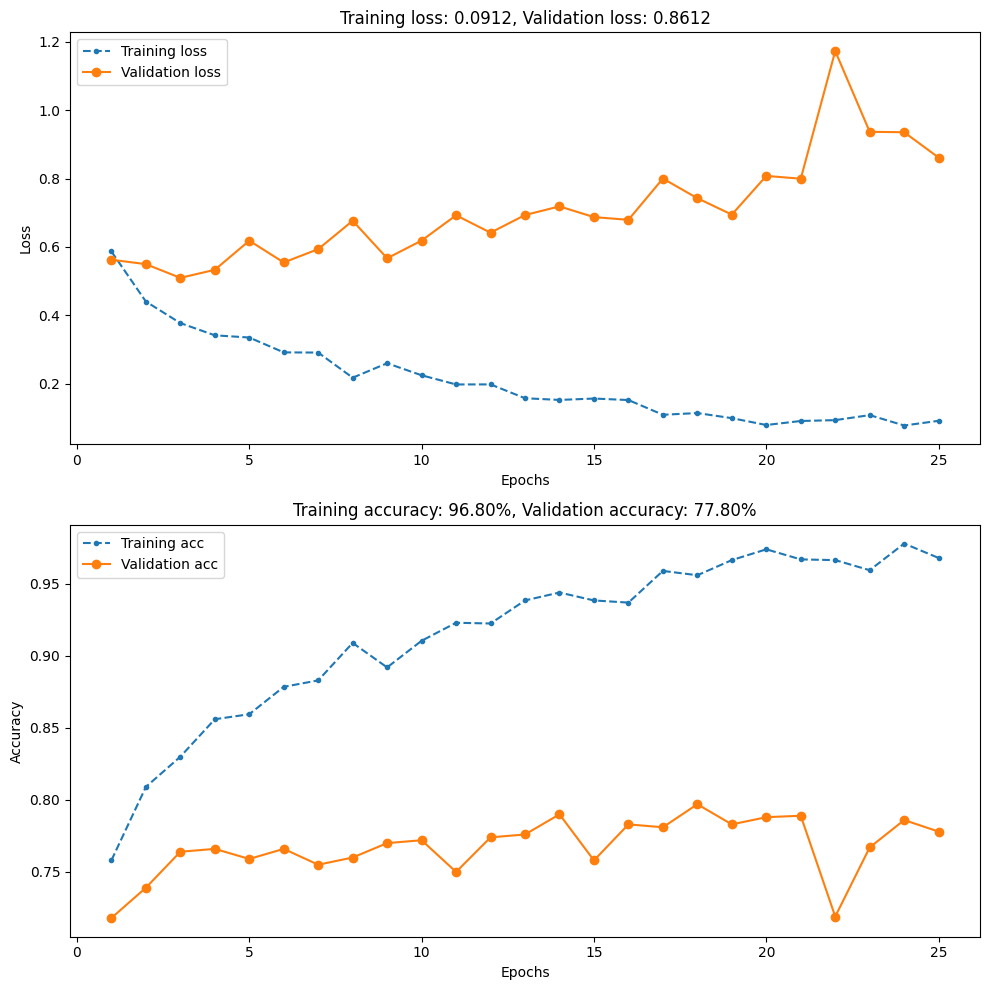

In [32]:
plot_loss_acc(history2)

This model starts with data augmentation, applying random flips, rotations, and zooms to increase training diversity and reduce overfitting. 

It includes four convolutional blocks, starting with 32 filters in the first block and increasing up to $256$ filters in the last. Each block applies batch normalization, max pooling, and dropout for stability and regularization. 

After the convolutional layers, a fully connected layer with $512$ neurons further processes the features, followed by a single-neuron output layer with sigmoid activation for binary classification.

The model is trained over $25$ epochs, using the Adam optimizer with binary cross-entropy loss, evaluated on accuracy.

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model1. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [42]:
image_size = [128, 128]
vgg16 = VGG16(input_shape=image_size + [3] , weights='imagenet',include_top=False)

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [50]:
for layers in vgg16.layers:
  layers.trainable=False

x = Flatten()(vgg16.output)
predict = Dense(1,activation='sigmoid')(x)
model_vgg16_mlp = Model(inputs = vgg16.inputs,outputs=predict)

In [51]:
model_vgg16_mlp.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')
model_vgg16_mlp.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,881 (56.16 MB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**(Question)** Compile and train your model1. You should be able to reach a validation accuracy >87%. Analyze your results and compare with your initial model trained from scratch.

In [52]:
history3 = model_vgg16_mlp.fit(augmented_train_dataset, validation_data=valid_dataset, epochs=25)

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7026 - loss: 0.5643 - val_accuracy: 0.8330 - val_loss: 0.3699
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8572 - loss: 0.3327 - val_accuracy: 0.8680 - val_loss: 0.3192
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8716 - loss: 0.2954 - val_accuracy: 0.8670 - val_loss: 0.3081
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.8948 - loss: 0.2733 - val_accuracy: 0.8680 - val_loss: 0.2899
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8882 - loss: 0.2647 - val_accuracy: 0.8710 - val_loss: 0.3097
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9102 - loss: 0.2461 - val_accuracy: 0.8760 - val_loss: 0.2807
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9112 - loss: 0.2322 - val_accuracy: 0.8750 - val_loss: 0.2874
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9184 - loss: 0.2082 - val_accuracy: 0.

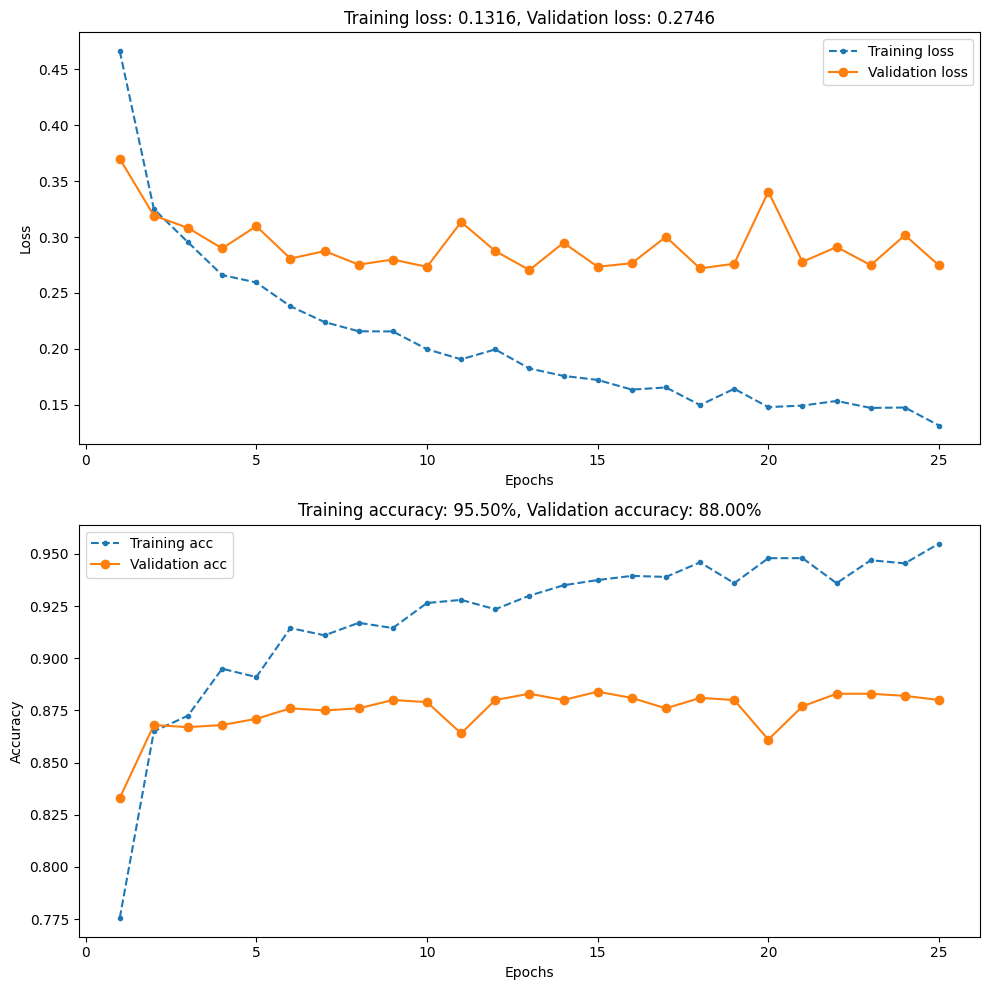

In [53]:
plot_loss_acc(history3)

In [58]:
def plot_loss_acc2(history1, history2):
    """Plot training and (optionally) validation loss and accuracy"""
    loss1 = history1.history['loss']
    acc1 = history1.history['accuracy']
    loss2 = history2.history['loss']
    acc2 = history2.history['accuracy']
    epochs = range(1, len(loss1) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss1, '.--', label='Training loss scratch')
    plt.plot(epochs, loss2, '.--', label='Training loss VVG16')
    final_loss = loss1[-1]
    final_loss1 = loss2[-1]
    title = 'Training loss scratch: {:.4f}'.format(final_loss)
    title += 'Training loss VVG16: {:.4f}'.format(final_loss1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history1.history:
        val_loss1 = history1.history['val_loss']
        plt.plot(epochs, val_loss1, 'o-', label='Validation loss scratch')
        final_val_loss1 = val_loss1[-1]
        title += ', Validation loss scratch: {:.4f}'.format(final_val_loss1)
    if 'val_loss' in history2.history:
        val_loss2 = history2.history['val_loss']
        plt.plot(epochs, val_loss2, '.--', label='Training loss VVG16')
        final_val_loss2 = val_loss2[-1]
        title += ', Validation loss VVG16: {:.4f}'.format(final_val_loss2)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc1, '.--', label='Training acc scratch')
    plt.plot(epochs, acc2, '.--', label='Training acc VVG16')
    final_acc1 = acc1[-1]
    final_acc2 = acc2[-1]
    title = 'Training accuracy scratch: {:.2f}%'.format(final_acc1 * 100)
    title += 'Training accuracy VVG16: {:.2f}%'.format(final_acc2 * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history1.history:
        val_acc1 = history1.history['val_accuracy']
        plt.plot(epochs, val_acc1, 'o-', label='Validation acc scratch')
        final_val_acc1 = val_acc1[-1]
        title += ', Validation accuracy scratch: {:.2f}%'.format(final_val_acc1 * 100)
    if 'val_accuracy' in history2.history:
        val_acc2 = history2.history['val_accuracy']
        plt.plot(epochs, val_acc2, 'o-', label='Validation acc VVG16')
        final_val_acc2 = val_acc2[-1]
        title += ', Validation accuracy VVG16: {:.2f}%'.format(final_val_acc2 * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

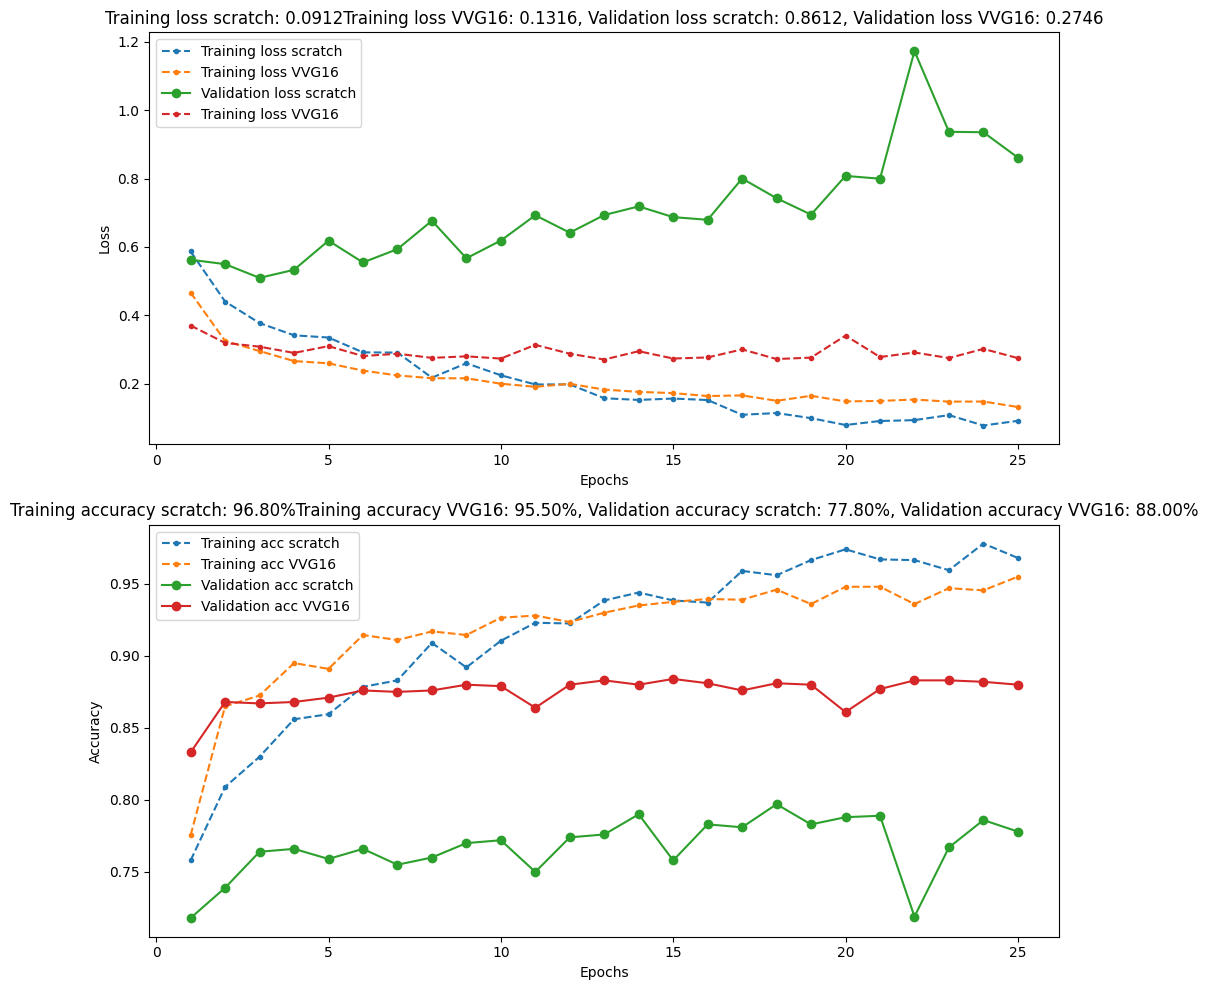

In [59]:
plot_loss_acc2(history2, history3)

Looking at the results, we clearly see that the model trained from VVG16 is better on the validation set $\approx 10\%$ better in average.

So we can conclude that if we have the time and the computing resources to import a pretrained model, we should do so to reach a better accuracy.